In [106]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


# Exploratory Data Analysis (EDA)

Due to limited time and the resources of my computer, I've made the following assumptions for this EDA notebook:

- **Reduced Dataset:** All experiments are conducted on a smaller dataset called `MDB_mini`, which is 10% of the main dataset.
- **Exclusion of Geo Data:** The analysis does not include any geolocation data.



#### 0. Load MDB-mini dataset
URL: https://huggingface.co/datasets/ai-lab/MBD-mini

In [2]:
url_prefix = 'https://huggingface.co/datasets/ai-lab/MDB_mini/resolve/main/'
folder_name = 'MDB_mini'

file_name_list = ['client_split', 'detail', 'ptls', 'targets']

! mkdir {folder_name}
for file_name in file_name_list:
    ! wget {url_prefix}{file_name}.tar.gz -O {folder_name}/{file_name}.tar.gz
    ! tar -xvzf {folder_name}/{file_name}.tar.gz -C {folder_name}/{file_name}
    

--2025-02-15 12:55:40--  https://huggingface.co/datasets/ai-lab/MBD/resolve/main/detail.tar.gz
Resolving huggingface.co (huggingface.co)... 2600:9000:275b:5c00:17:b174:6d00:93a1, 2600:9000:275b:7600:17:b174:6d00:93a1, 2600:9000:275b:9c00:17:b174:6d00:93a1, ...
Connecting to huggingface.co (huggingface.co)|2600:9000:275b:5c00:17:b174:6d00:93a1|:443... connected.
302 Foundest sent, awaiting response... 
Location: https://cdn-lfs-us-1.hf.co/repos/5e/ba/5eba0f32c5a84b02c5537f98c64717c72218204ecb39e6b2badfbd8ec139301e/15f025d83800a3b92022497ee973529e51006d56bdd3d36a577e35931bc3eecb?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27detail.tar.gz%3B+filename%3D%22detail.tar.gz%22%3B&response-content-type=application%2Fgzip&Expires=1739627740&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczOTYyNzc0MH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzVlL2JhLzVlYmEwZjMyYzVhODRiMDJjNTUzN2Y5OGM2NDcxN2M3MjIxODIwNGVjYjM5ZTZiMmJhZGZi

In [5]:
def load_data(folder_path, save_fold=False):
    N_FOLDS = 5
    storage = []
    for fold in range(N_FOLDS):
        sub_folder_path = os.path.join(folder_path, f'fold={fold}')
        for file_name in tqdm(os.listdir(sub_folder_path)):
            file_path = os.path.join(sub_folder_path, file_name)
            if file_name.endswith('.c000.snappy.parquet'):
                df_ = pd.read_parquet(file_path)
                if save_fold:
                    df_['fold'] = [fold for _ in df_.index]
                storage.append(df_)
    
    return pd.concat(storage, ignore_index=True)

### 1. Transactions


In [6]:
### Load data

df_trx = load_data('MBD_mini/detail/trx')

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

#### 1.1 General Info

In [459]:
df_trx.shape

(38764930, 14)

In [8]:
df_trx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38764930 entries, 0 to 38764929
Data columns (total 14 columns):
 #   Column         Dtype         
---  ------         -----         
 0   client_id      object        
 1   event_time     datetime64[ns]
 2   amount         float32       
 3   event_type     int32         
 4   event_subtype  int32         
 5   currency       float64       
 6   src_type11     float64       
 7   src_type12     float64       
 8   dst_type11     float64       
 9   dst_type12     float64       
 10  src_type21     float64       
 11  src_type22     float64       
 12  src_type31     float64       
 13  src_type32     float64       
dtypes: datetime64[ns](1), float32(1), float64(9), int32(2), object(1)
memory usage: 3.6+ GB


In [11]:
df_trx.describe()

,event_time,amount,event_type,event_subtype,currency,src_type11,src_type12,dst_type11,dst_type12,src_type21,src_type22,src_type31,src_type32
count,38764930,3.876493e+07,3.876493e+07,3.876493e+07,3.876481e+07,3.854757e+07,3.854757e+07,3.852111e+07,3.852111e+07,3.872264e+07,3.872264e+07,3.868593e+07,3.868593e+07
mean,2022-01-05 17:54:52.474902016,1.304899e+06,2.222725e+01,2.727393e+01,1.099689e+01,3.719957e+01,2.383623e+02,7.336910e+02,2.076017e+04,2.440500e+04,3.441446e+01,1.192344e+03,3.969164e+01
min,2020-12-31 21:00:02.169545,3.021821e-06,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,5.000000e+00,9.500000e+01,7.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,2021-07-07 06:10:24.942164224,2.453869e+03,1.000000e+00,1.200000e+01,1.100000e+01,2.200000e+01,4.700000e+01,3.060000e+02,1.606700e+04,1.330600e+04,8.000000e+00,5.500000e+02,1.900000e+01
50%,2021-12-31 18:24:54.437207040,1.803584e+04,1.100000e+01,1.900000e+01,1.100000e+01,2.200000e+01,4.700000e+01,7.800000e+02,2.161900e+04,2.420600e+04,2.500000e+01,1.127000e+03,3.500000e+01
75%,2022-07-10 06:00:49.388631296,9.475954e+04,4.600000e+01,4.000000e+01,1.100000e+01,2.200000e+01,4.650000e+02,7.930000e+02,2.676600e+04,3.640300e+04,5.400000e+01,1.846000e+03,6.000000e+01
max,2022-12-31 20:59:58.460193,1.370187e+12,5.600000e+01,6.200000e+01,1.700000e+01,1.860000e+02,1.143000e+03,1.753000e+03,3.305500e+04,4.892300e+04,8.800000e+01,2.506000e+03,8.900000e+01
std,NaN,4.804460e+08,2.127025e+01,1.646026e+01,2.122565e-01,3.730559e+01,3.173109e+02,4.860614e+02,7.115975e+03,1.374799e+04,2.695360e+01,7.404839e+02,2.306618e+01


In [12]:
df_trx.isnull().sum()

client_id             0
event_time            0
amount                0
event_type            0
event_subtype         0
currency            118
src_type11       217361
src_type12       217361
dst_type11       243824
dst_type12       243824
src_type21        42293
src_type22        42293
src_type31        78996
src_type32        78996
dtype: int64

#### 1.2 Seasons

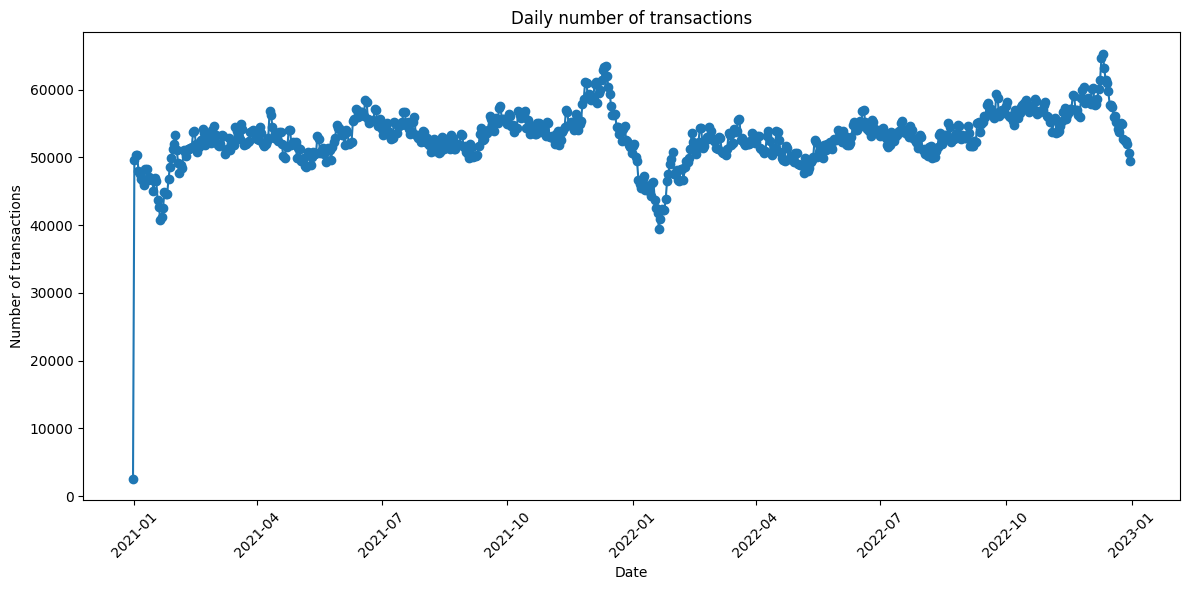

In [13]:
df_trx['event_time'] = pd.to_datetime(df_trx['event_time'])

daily_trx = df_trx.groupby(df_trx['event_time'].dt.date).size().reset_index(name='trx_count')
daily_trx['event_time'] = pd.to_datetime(daily_trx['event_time'])

plt.figure(figsize=(12, 6))
plt.plot(daily_trx['event_time'], daily_trx['trx_count'], marker='o', linestyle='-')
plt.title("Daily number of transactions")
plt.xlabel("Date")
plt.ylabel("Number of transactions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### 1.3 Currencies

/tmp/ipykernel_3100375/3656950584.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=trx_by_currency, x='currency', y='transaction_count', palette='viridis')


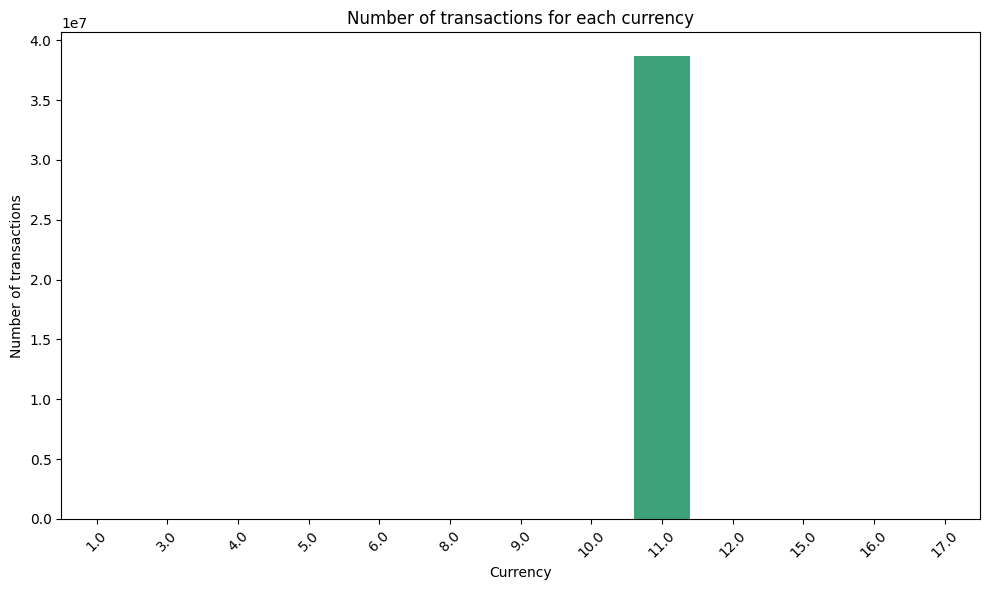

In [15]:
trx_by_currency = df_trx.groupby('currency').size().reset_index(name='transaction_count')

plt.figure(figsize=(10,6))
sns.barplot(data=trx_by_currency, x='currency', y='transaction_count', palette='viridis')
plt.title("Number of transactions for each currency")
plt.xlabel("Currency")
plt.ylabel("Number of transactions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [18]:
trx_by_currency.sort_values('transaction_count', ascending=False)

,currency,transaction_count
8,11.0,38724240
1,3.0,20324
10,15.0,16041
2,4.0,3128
12,17.0,446
7,10.0,199
5,8.0,174
0,1.0,159
4,6.0,82
11,16.0,7


#### 1.4 Top-5 currencies: histagram of ammounts

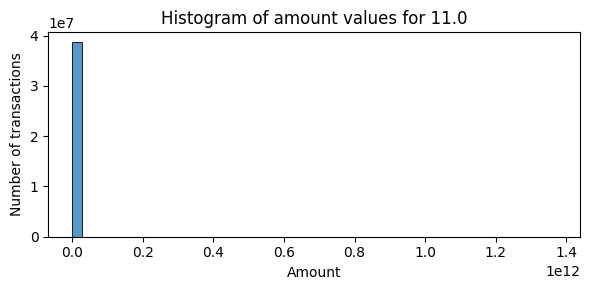

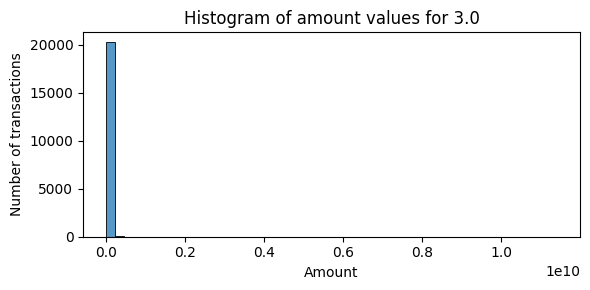

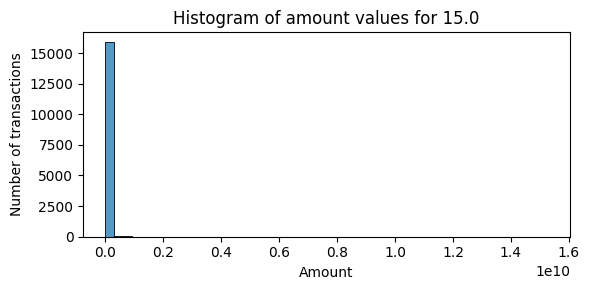

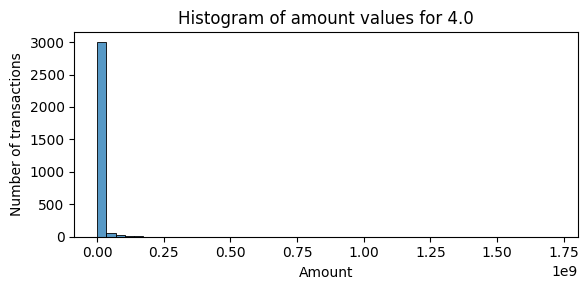

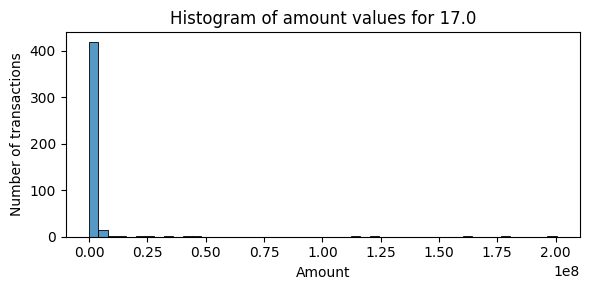

In [20]:
top5_currencies = trx_by_currency.sort_values(by='transaction_count', ascending=False).head(5)['currency']

for currency_idx in top5_currencies.values:
    df_currency = df_trx[df_trx['currency'] == currency_idx]
    
    plt.figure(figsize=(6, 3))
    sns.histplot(data=df_currency, x='amount', bins=50, kde=False)
    plt.title(f"Histogram of amount values for {currency_idx}")
    plt.xlabel("Amount")
    plt.ylabel("Number of transactions")
    plt.tight_layout()
    plt.show()


In [21]:
### Let's consider the transaction > 0.95 quantile as outliers
### And plot histogram without them 

df_trx['threshold_95'] = df_trx.groupby('currency')['amount'].transform(lambda x: x.quantile(0.95))
df_trx['is_outlier'] = (df_trx['amount'] > df_trx['threshold_95']).astype(int)
df_trx.drop('threshold_95', axis=1, inplace=True)
outlier_rate = df_trx.groupby('currency')['is_outlier'].mean().reset_index()
print(outlier_rate)

    currency  is_outlier
0        1.0    0.050314
1        3.0    0.050039
2        4.0    0.050192
3        5.0    0.166667
4        6.0    0.060976
5        8.0    0.051724
6        9.0    0.500000
7       10.0    0.050251
8       11.0    0.050000
9       12.0    0.250000
10      15.0    0.049997
11      16.0    0.142857
12      17.0    0.051570


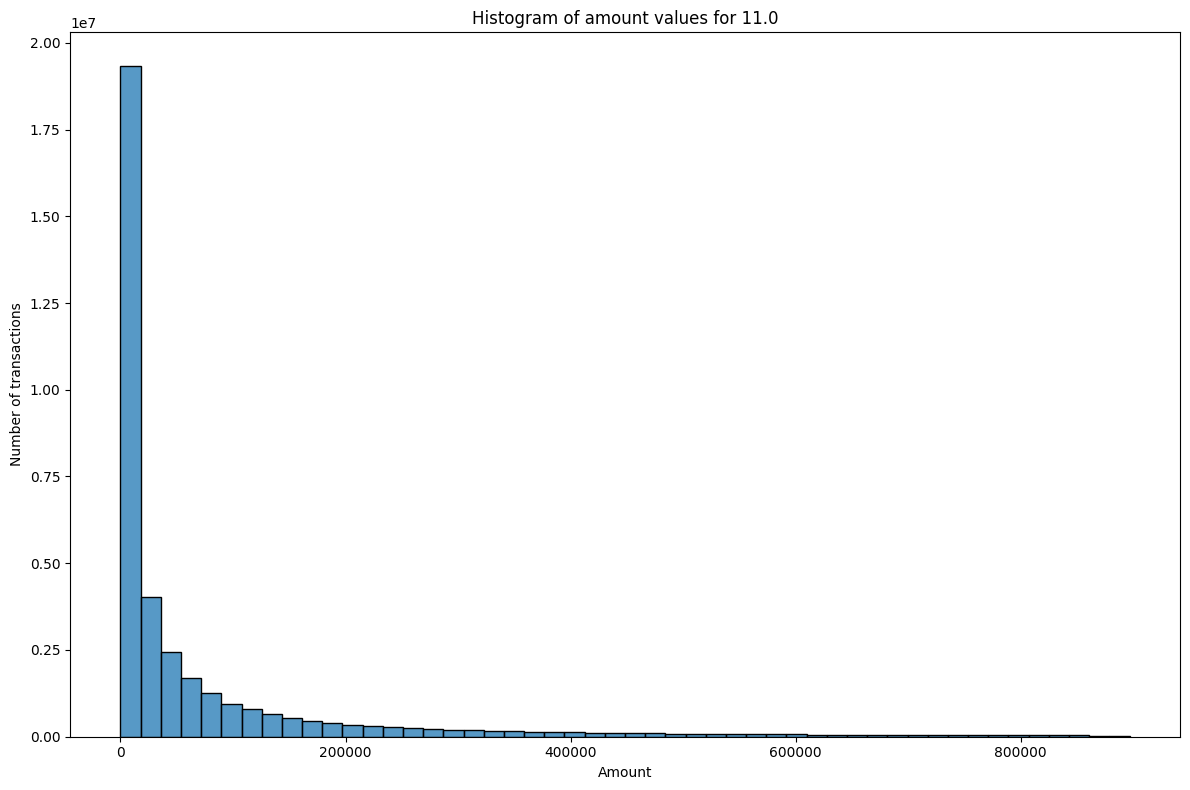

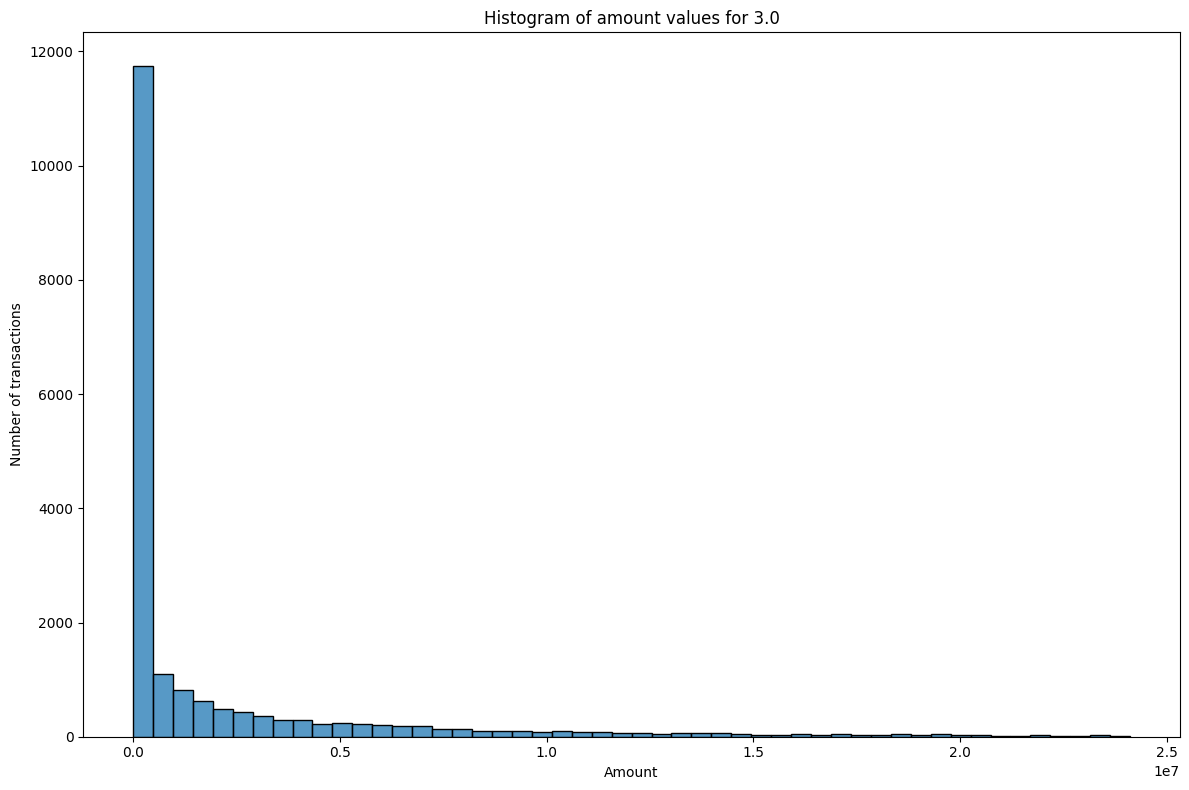

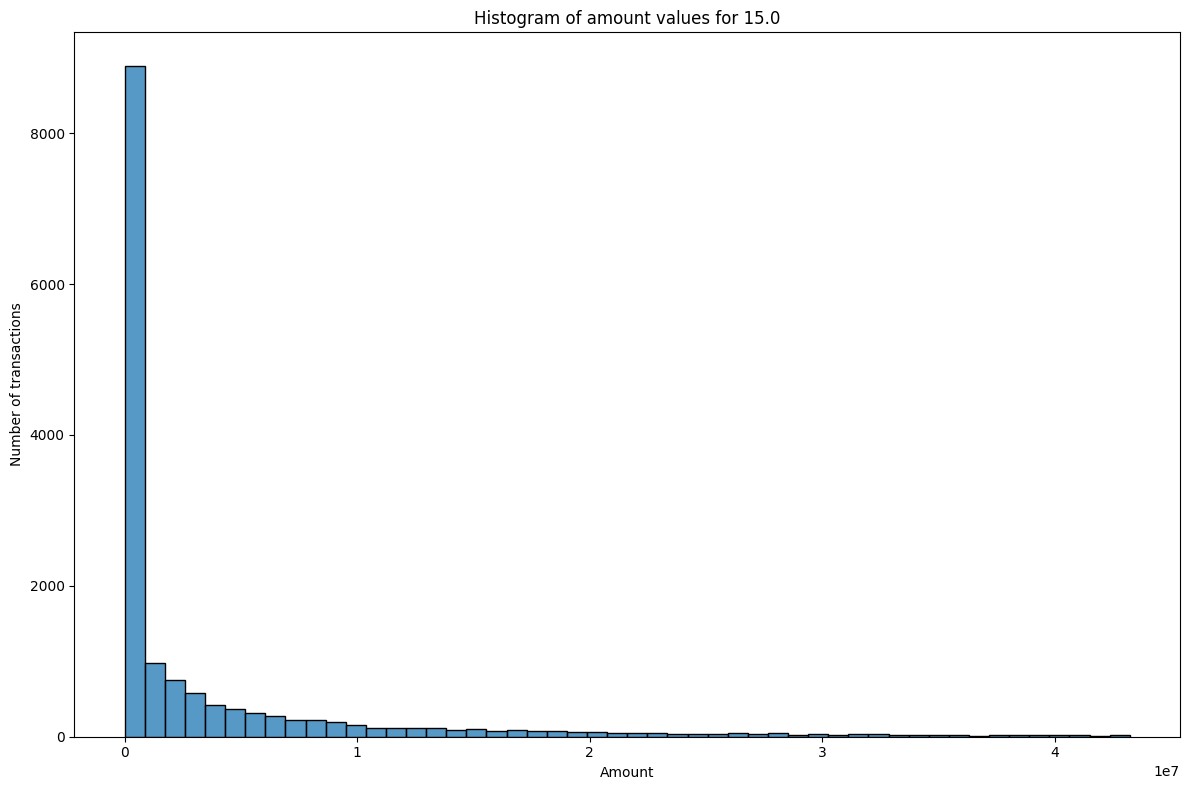

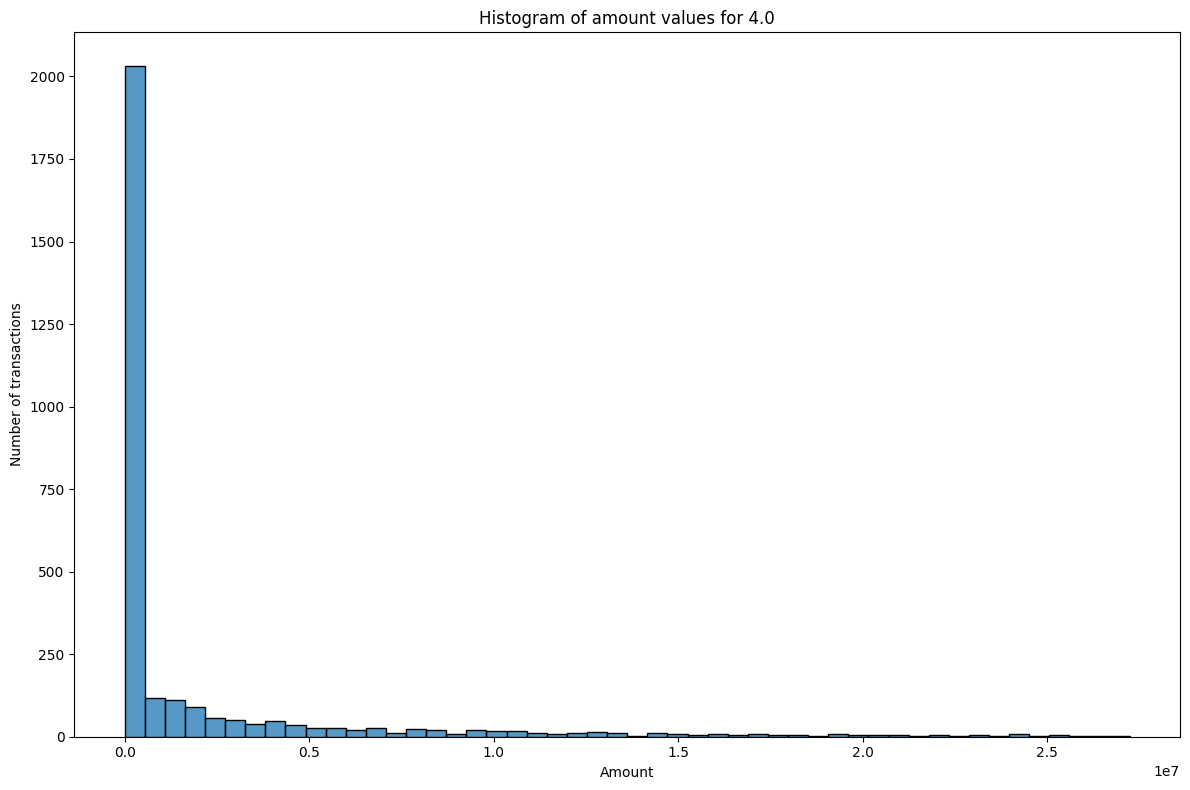

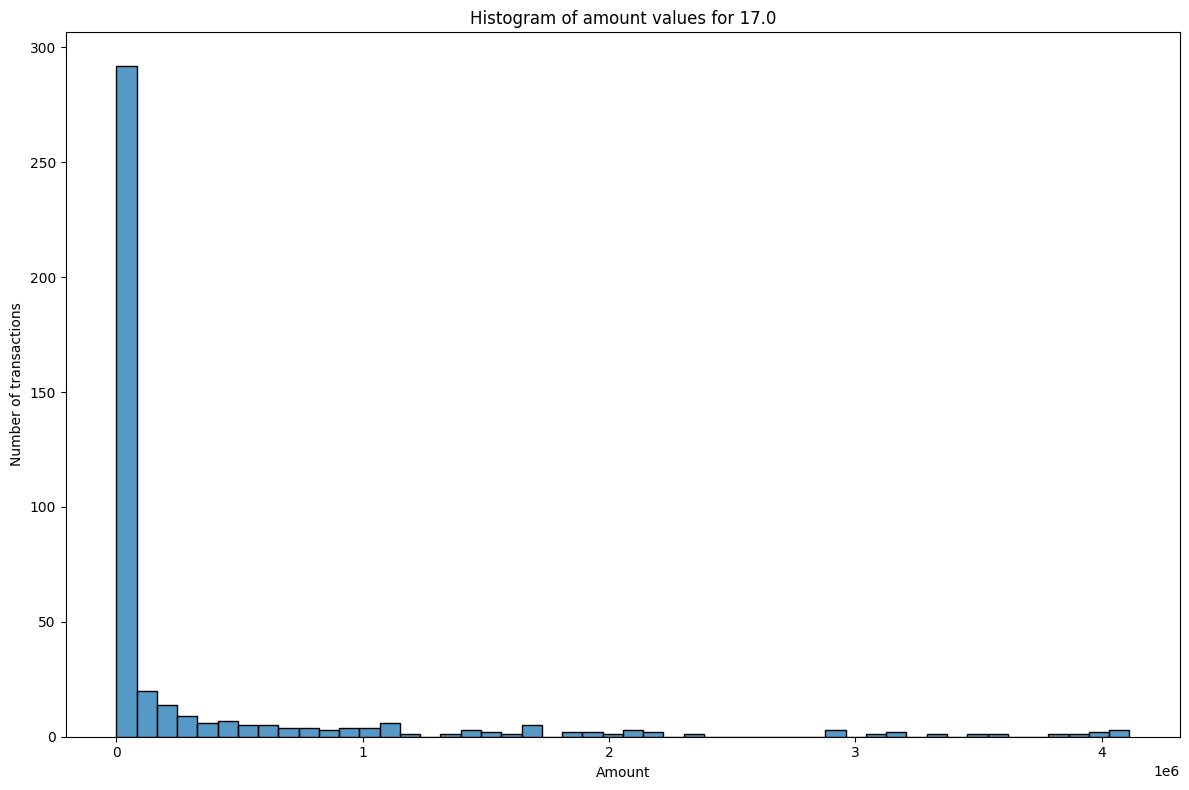

In [22]:
for currency_idx in top5_currencies.values:
    df_currency = df_trx[(df_trx['currency'] == currency_idx) * (df_trx['is_outlier'] != 1)]
    
    plt.figure(figsize=(12,8))
    sns.histplot(data=df_currency, x='amount', bins=50, kde=False)
    plt.title(f"Histogram of amount values for {currency_idx}")
    plt.xlabel("Amount")
    plt.ylabel("Number of transactions")
    plt.tight_layout()
    plt.show()

#### 1.5 Distribution of transactions during the day 

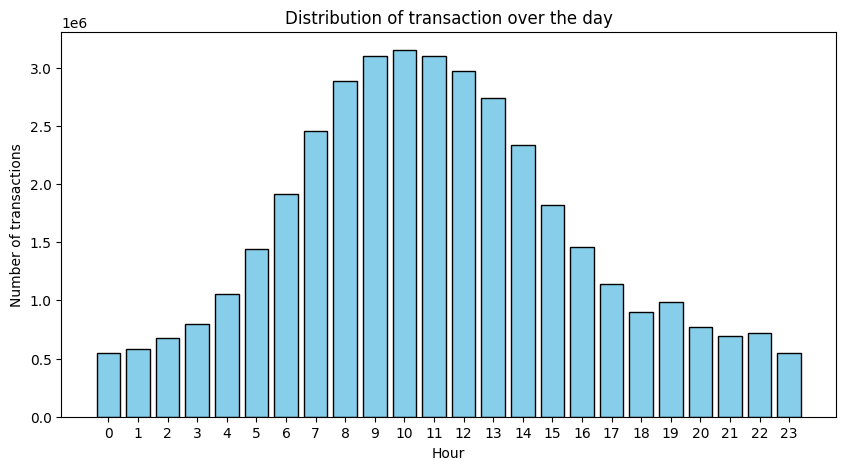

In [24]:
df_trx['hour'] = df_trx['event_time'].dt.hour

trx_by_hour = df_trx.groupby('hour').size().reset_index(name='transaction_count')

plt.figure(figsize=(10, 5))
plt.bar(trx_by_hour['hour'], trx_by_hour['transaction_count'], color='skyblue', edgecolor='black')
# plt.hist(df_dialogs['hour'], bins=24, range=(0, 23), color='skyblue', edgecolor='black')
plt.title('Distribution of transaction over the day')
plt.xlabel('Hour')
plt.ylabel("Number of transactions")
plt.xticks(range(0, 24))
plt.show()

#### 1.6 Distribution of median intervals between transactions

Aggregated time interval between transactions for some clients:
                                           client_id  \
0  000032cc38caee45fe031778bcf6af05aa2aabe476acb8...   
1  00005e39da5fb5968996cd49130281c8bd074a42e0e17a...   
2  00012766278a7b25ddd3d6de329a44dec4c278d5807fae...   
3  0001edbc5ab720f70a615ed9e8429df9b6c3f3c3999a51...   
4  0002ddd816198d32474486d54f4bfe4f7b361119b5dc45...   

                       mean                    median  mean_days  median_days  
0 1 days 08:57:40.194506997 0 days 11:34:58.588501500   1.373382     0.482623  
1 9 days 03:10:27.536604166    7 days 01:07:36.216282   9.132263     7.046947  
2 2 days 02:29:48.771954777    1 days 18:14:53.597092   2.104037     1.760343  
3 2 days 05:20:50.174812293    1 days 20:22:53.540092   2.222803     1.849231  
4 1 days 03:11:34.685633975    0 days 22:24:32.681361   1.133040     0.933712  


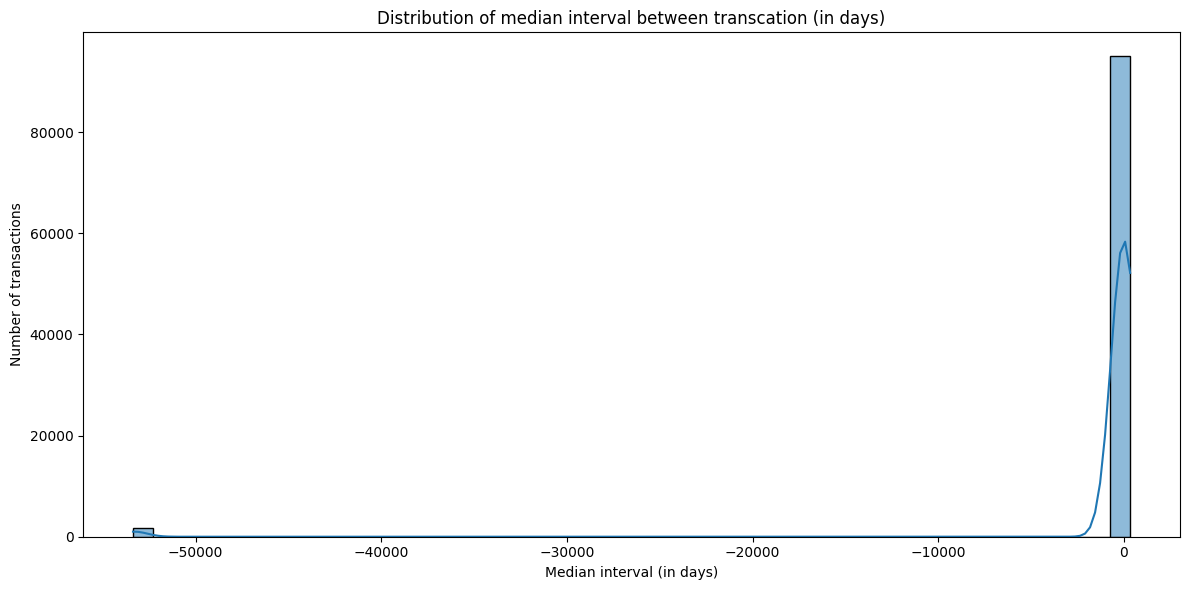

In [25]:
df_trx = df_trx.sort_values(['client_id', 'event_time'])
df_trx['time_diff'] = df_trx.groupby('client_id')['event_time'].diff()

client_time_diff = df_trx.groupby('client_id')['time_diff'].agg(['mean', 'median']).reset_index()

client_time_diff['mean_days'] = client_time_diff['mean'].dt.total_seconds() / (3600 * 24)
client_time_diff['median_days'] = client_time_diff['median'].dt.total_seconds() / (3600 * 24)

print('Aggregated time interval between transactions for some clients:')
print(client_time_diff.head())

plt.figure(figsize=(12, 6))
sns.histplot(client_time_diff['median_days'], bins=50, kde=True)
plt.title("Distribution of median interval between transcation (in days)")
plt.xlabel("Median interval (in days)")
plt.ylabel("Number of transactions")
plt.tight_layout()
plt.show()


In [474]:
df_trx.currency.value_counts()

currency
11.0    38724240
3.0        20324
15.0       16041
4.0         3128
17.0         446
10.0         199
8.0          174
1.0          159
6.0           82
16.0           7
5.0            6
12.0           4
9.0            2
Name: count, dtype: int64

#### 1.7 Events & Sub-events of transactions

/tmp/ipykernel_3100375/3544922297.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_trx, x='event_type', palette='viridis')


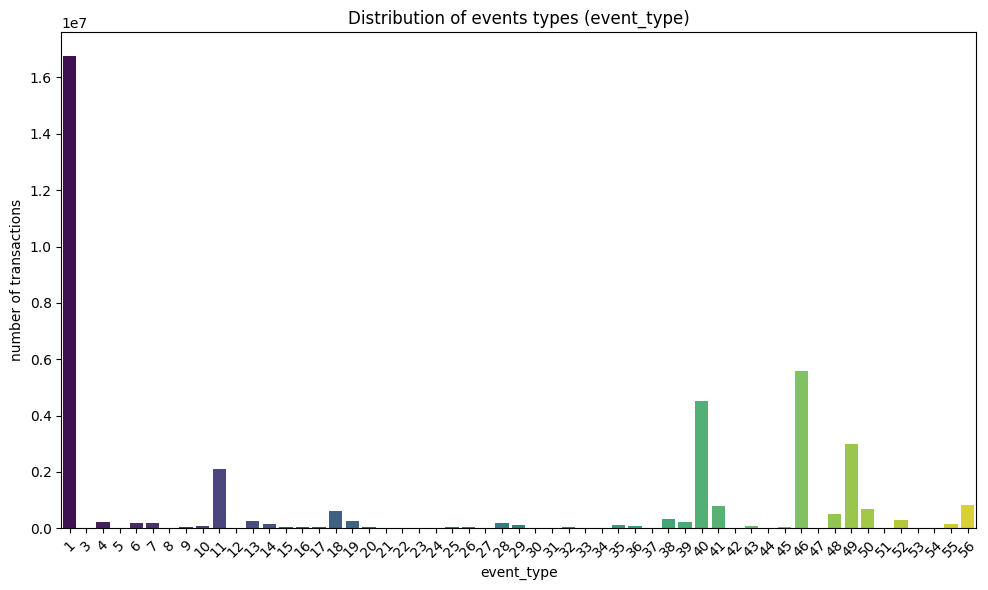

In [26]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_trx, x='event_type', palette='viridis')
plt.title("Distribution of events types (event_type)")
plt.xlabel("event_type")
plt.ylabel("Number of transactions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipykernel_3100375/2814181766.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_trx, x='event_subtype', palette='magma')


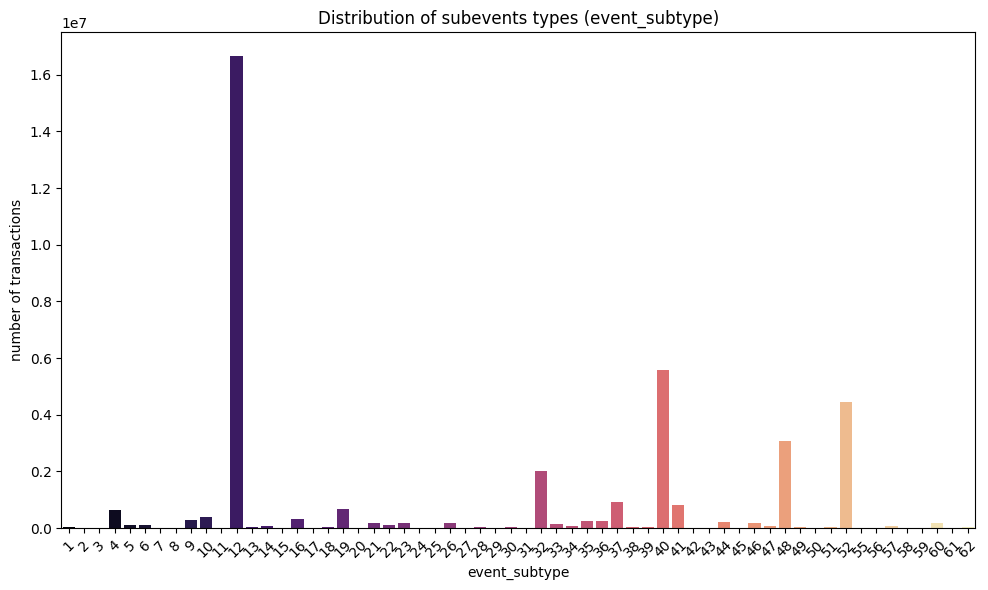

In [27]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_trx, x='event_subtype', palette='magma')
plt.title("Distribution of subevents types (event_subtype)")
plt.xlabel("event_subtype")
plt.ylabel("Number of transactions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 1.8 Sender & Contractor Features

/tmp/ipykernel_3100375/3423496403.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_data, x=col, y='count', palette='magma')


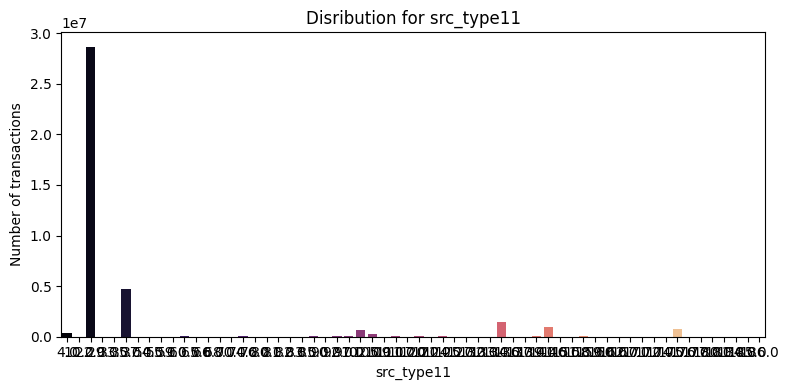

/tmp/ipykernel_3100375/3423496403.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_data, x=col, y='count', palette='magma')


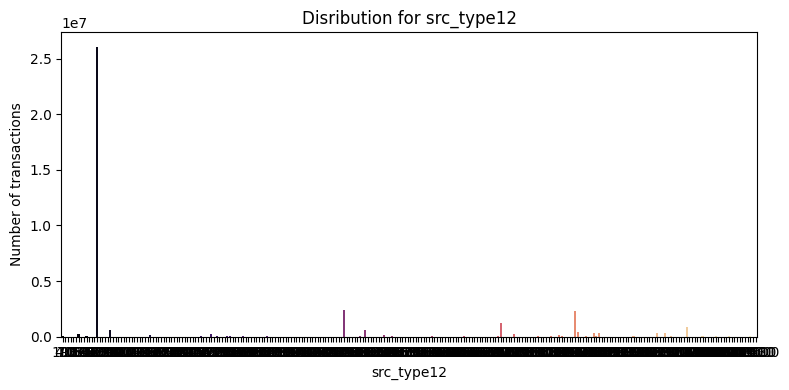

/tmp/ipykernel_3100375/3423496403.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_data, x=col, y='count', palette='magma')


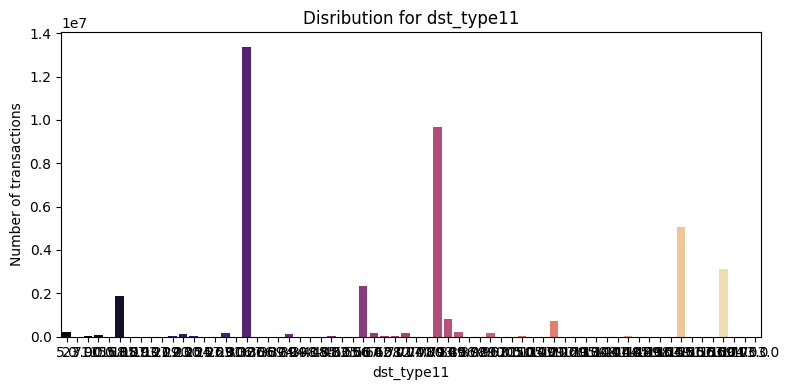

/tmp/ipykernel_3100375/3423496403.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_data, x=col, y='count', palette='magma')


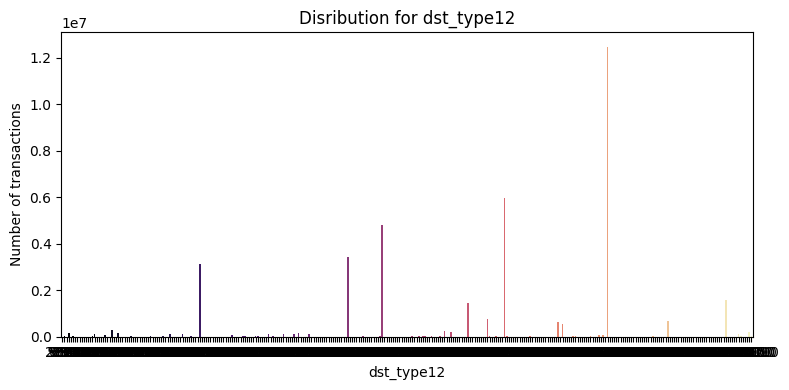

/tmp/ipykernel_3100375/3423496403.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_data, x=col, y='count', palette='magma')


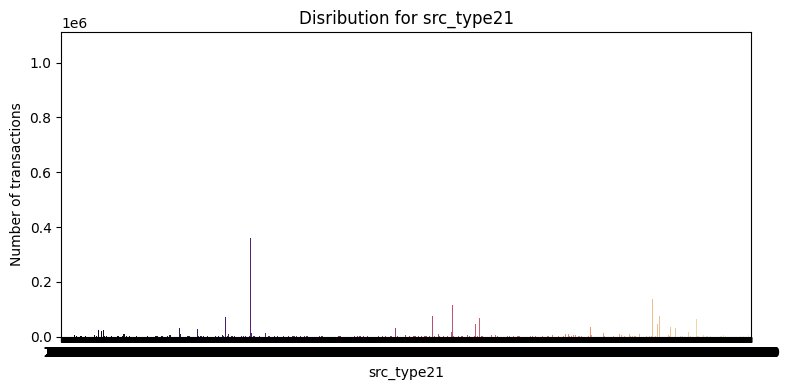

/tmp/ipykernel_3100375/3423496403.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_data, x=col, y='count', palette='magma')


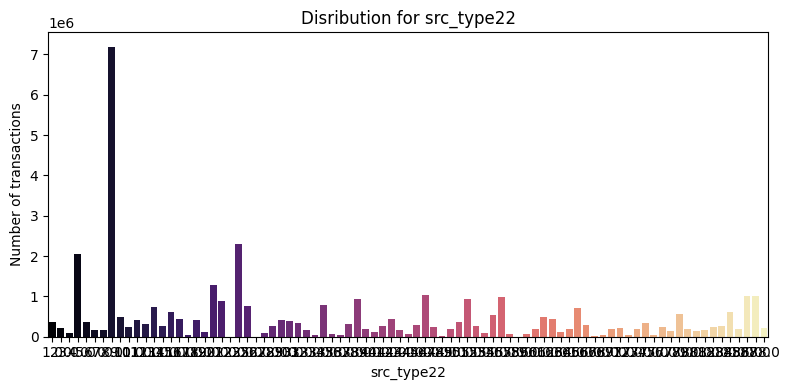

/tmp/ipykernel_3100375/3423496403.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_data, x=col, y='count', palette='magma')


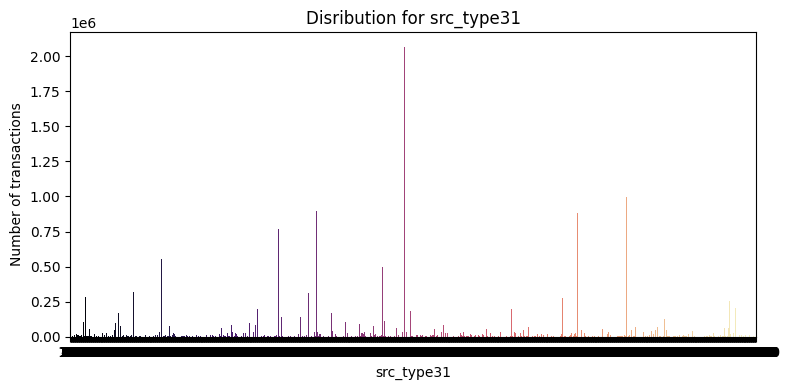

/tmp/ipykernel_3100375/3423496403.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_data, x=col, y='count', palette='magma')


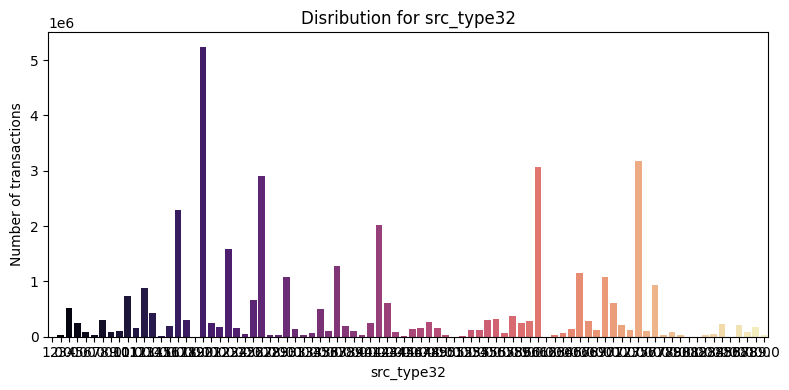

In [30]:
cols = ['src_type11', 'src_type12', 'dst_type11', 'dst_type12',
        'src_type21', 'src_type22', 'src_type31', 'src_type32']

for col in cols:

    grouped_data = df_trx.groupby(col).size().reset_index(name='count')
    
    plt.figure(figsize=(8, 4))
    sns.barplot(data=grouped_data, x=col, y='count', palette='magma')
    plt.title(f"Disribution for {col}")
    plt.xlabel(col)
    plt.ylabel("Number of transactions")
    plt.tight_layout()
    plt.show()

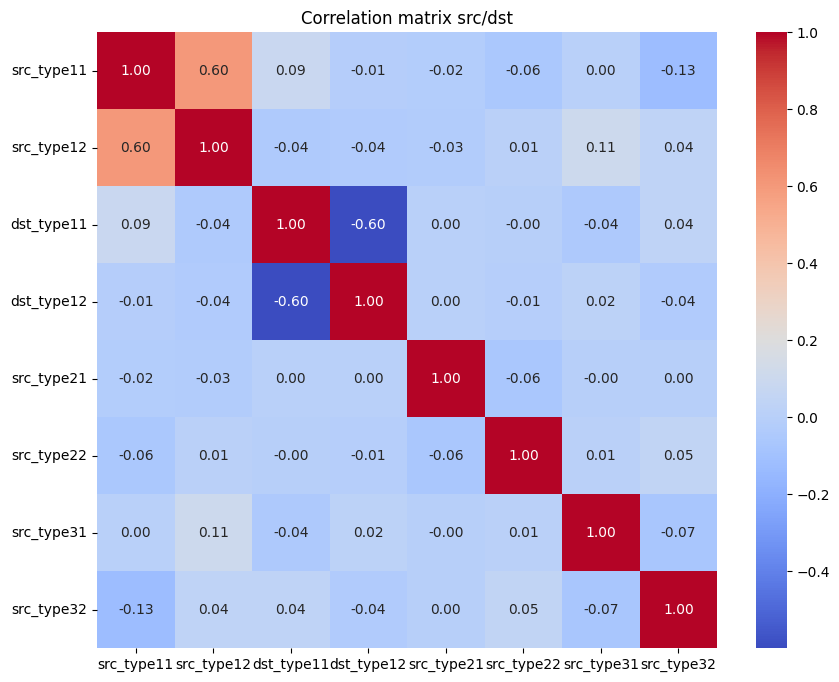

In [31]:
### Correlation
corr_matrix = df_trx[cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix src/dst")
plt.show()


In [33]:
### Are there any matches?
src_columns = ['src_type11', 'src_type12', 'src_type21', 'src_type22', 'src_type31', 'src_type32']
dst_columns = ['dst_type11', 'dst_type12']

results = []

for src in src_columns:
    for dst in dst_columns:
        match_count = (df_trx[src] == df_trx[dst]).sum()
        results.append({
            'src_column': src,
            'dst_column': dst,
            'match_count': match_count
        })

results_df = pd.DataFrame(results)
results_df


,src_column,dst_column,match_count
0,src_type11,dst_type11,0
1,src_type11,dst_type12,0
2,src_type12,dst_type11,1
3,src_type12,dst_type12,0
4,src_type21,dst_type11,950
5,src_type21,dst_type12,539
6,src_type22,dst_type11,2072
7,src_type22,dst_type12,0
8,src_type31,dst_type11,22190
9,src_type31,dst_type12,51


### 2. Target

In [115]:
### Load data

df_targets = load_data('MBD_mini/targets')
df_targets['date'] = df_targets['mon']

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

In [116]:
df_targets['mon'] = pd.to_datetime(df_targets['date']) #+ pd.DateOffset(months=1)
df_targets['mon'] = df_targets['mon'].dt.to_period('M').dt.to_timestamp()

In [36]:
df_targets.head(2)

,client_id,mon,target_1,target_2,target_3,target_4,trans_count,diff_trans_date,date
0,00112e0ce2b5d48c4e83ced4c0d01b8941c9f42177be81...,2022-02-28,0,0,0,0,0,NaN,2022-02-28
1,00112e0ce2b5d48c4e83ced4c0d01b8941c9f42177be81...,2022-03-31,0,0,0,0,2,24.0,2022-03-31


#### 2.1 Imbalance

In [39]:
for target_id in range(1, 5):
    column = f'target_{target_id}'
    counts = df_targets[column].value_counts()
    percentages = df_targets[column].value_counts(normalize=True).mul(100).round(2)
    
    print(f"\nDistribution for {column}:")
    for value in counts.index:
        print(f"Value {value}: {counts[value]} ({percentages[value]}%)")


Distribution for target_1:
Value 0: 1197326 (99.55%)
Value 1: 5362 (0.45%)

Distribution for target_2:
Value 0: 1202111 (99.95%)
Value 1: 577 (0.05%)

Distribution for target_3:
Value 0: 1198158 (99.62%)
Value 1: 4530 (0.38%)

Distribution for target_4:
Value 0: 1199628 (99.75%)
Value 1: 3060 (0.25%)


#### 1.2 Correlation

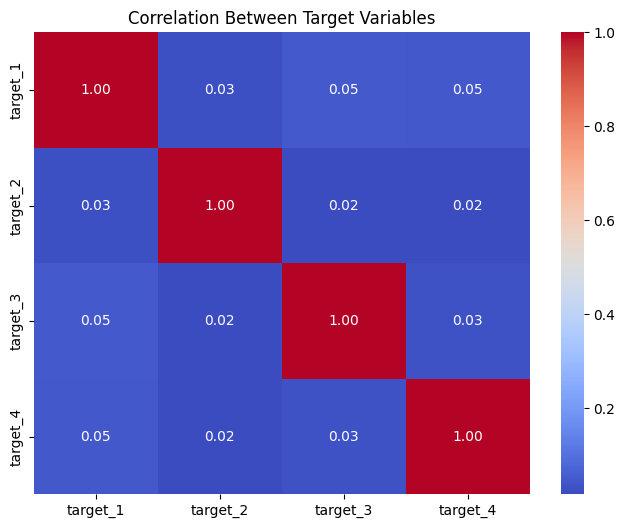

In [40]:
target_columns = [f'target_{i}' for i in range(1, 5)]
corr_matrix = df_targets[target_columns].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Target Variables")
plt.show()


### 3. Dialogs

In [113]:
### Load data
df_dialogs = load_data('MBD_mini/detail/dialog')

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

In [114]:
df_dialogs['mon'] = df_dialogs['event_time'].dt.to_period('M').dt.to_timestamp()
df_dialogs['mon'] = df_dialogs['mon'] + pd.offsets.MonthBegin(1)

#### 3.1 Seasons

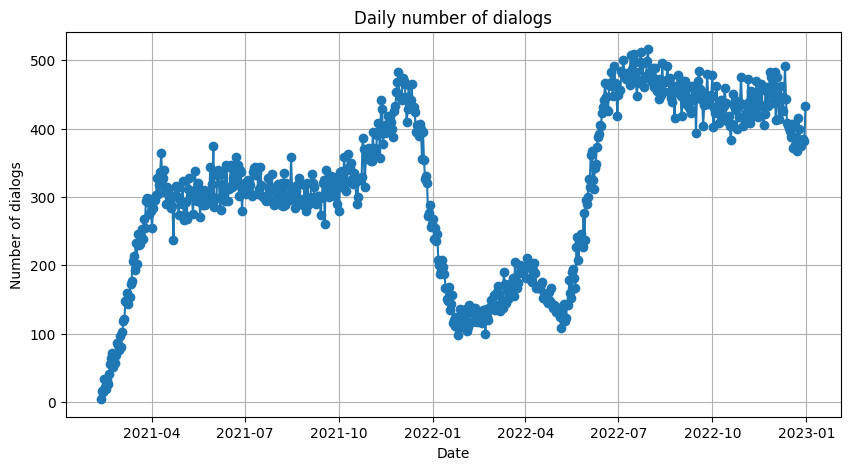

In [42]:
df_dialogs['date'] = df_dialogs['event_time'].dt.date
dialogs_per_date = df_dialogs.groupby('date').size()

plt.figure(figsize=(10, 5))
dialogs_per_date.plot(kind='line', marker='o')
plt.title("Daily number of dialogs")
plt.xlabel('Date')
plt.ylabel('Number of dialogs')
plt.grid(True)
plt.show()

#### 3.2 Distribution of dialogs during the day

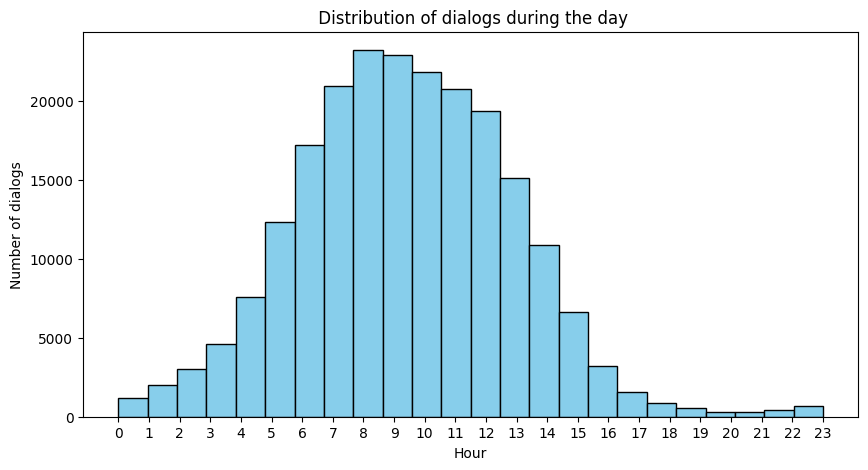

In [43]:
df_dialogs['hour'] = df_dialogs['event_time'].dt.hour

plt.figure(figsize=(10, 5))
plt.hist(df_dialogs['hour'], bins=24, range=(0, 23), color='skyblue', edgecolor='black')
plt.title(' Distribution of dialogs during the day')
plt.xlabel('Hour')
plt.ylabel('Number of dialogs')
plt.xticks(range(0, 24))
plt.show()

#### 1.3 Distribution of number of dialods over clients

Number of clients with an outlying number of dialogues: 2005


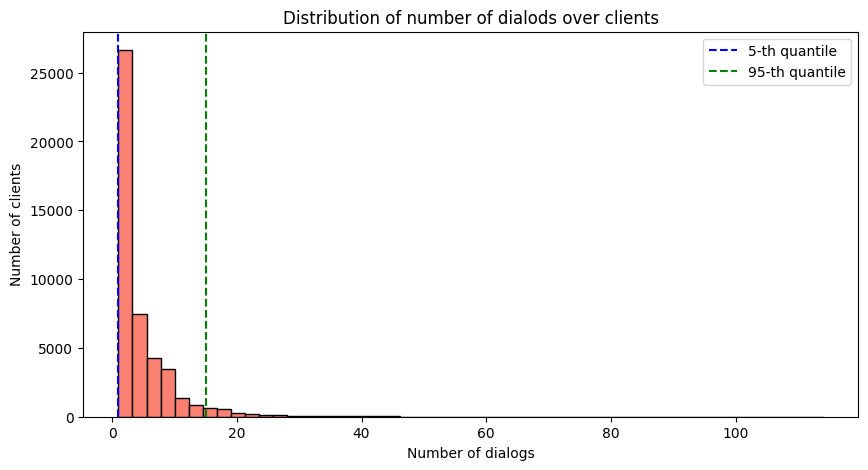

In [125]:
dialogs_per_client = df_dialogs.groupby('client_id').size()

### Quantile 
lower_quantile = dialogs_per_client.quantile(0.05)
upper_quantile = dialogs_per_client.quantile(0.95)

anomalous_low = dialogs_per_client[dialogs_per_client < lower_quantile]
anomalous_high = dialogs_per_client[dialogs_per_client > upper_quantile]

print("Number of clients with an outlying number of dialogues:", anomalous_high.shape[0])

plt.figure(figsize=(10, 5))
plt.hist(dialogs_per_client, bins=50, color='salmon', edgecolor='black')
plt.axvline(lower_quantile, color='blue', linestyle='--', label='5-th quantile')
plt.axvline(upper_quantile, color='green', linestyle='--', label='95-th quantile')
plt.xlabel('Number of dialogs')
plt.ylabel('Number of clients')
plt.title('Distribution of number of dialods over clients')
plt.legend()
plt.show()

#### 1.4 Number of dialogs VS Purchases in the next month

In [81]:
df_dialogs_monthly = (
    df_dialogs
    .groupby(['client_id', 'mon'])
    .size()
    .reset_index(name='dialog_count')
)

df_merged = pd.merge(
    df_targets,
    df_dialogs_monthly,
    on=['client_id', 'mon'],  
    how='left' 
)
# df_merged = df_merged[~df_merged['dialog_count'].isna()]
df_merged['dialog_count'] = df_merged['dialog_count'].fillna(0)

df_merged['target'] = df_merged[['target_1', 'target_2', 'target_3', 'target_4',]].max(axis=1)

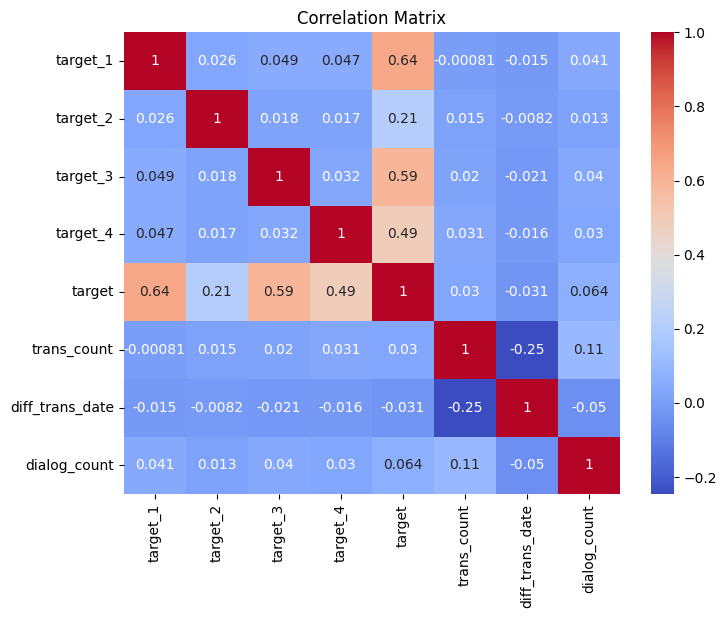

In [85]:
corr_cols = ['target_1', 'target_2', 'target_3', 'target_4', 'target', 
             'trans_count', 'diff_trans_date', 
             'dialog_count']

corr_matrix = df_merged[corr_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### 1.5 Dialogs in weeks VS Targets

In [89]:
df_dialogs['week_of_month'] = ((df_dialogs['event_time'].dt.day - 1) // 7) + 1
df_dialogs['max_week'] = df_dialogs.groupby(['client_id', 'mon'])['week_of_month'].transform('max')
df_dialogs['reversed_week'] = df_dialogs['max_week'] - df_dialogs['week_of_month'] + 1

df_week_counts = df_dialogs.groupby(['client_id', 'mon', 'reversed_week']).size().reset_index(name='calls')

df_week_pivot = df_week_counts.pivot_table(index=['client_id', 'mon'], 
                                           columns='reversed_week', 
                                           values='calls', 
                                           fill_value=0).reset_index()

def rename_week(col):
    if isinstance(col, (int, np.integer)):
        if col == 1:
            return 'calls_last_week'
        else:
            return f'calls_{col}th_last_week'
    return col

df_week_pivot.rename(columns=lambda x: rename_week(x), inplace=True)

df_merged = pd.merge(
    df_targets,
    df_week_pivot,
    on=['client_id', 'mon'],  
    how='left'  
)
df_merged['target'] = df_merged[['target_1', 'target_2', 'target_3', 'target_4',]].max(axis=1)
# df_merged = df_merged[~df_merged['dialog_count'].isna()]
# df_merged['dialog_count'] = df_merged['dialog_count'].fillna(0)

In [90]:
df_merged.columns

Index(['client_id', 'mon', 'target_1', 'target_2', 'target_3', 'target_4',
       'trans_count', 'diff_trans_date', 'date', 'calls_last_week',
       'calls_2th_last_week', 'calls_3th_last_week', 'calls_4th_last_week',
       'calls_5th_last_week', 'target'],
      dtype='object')

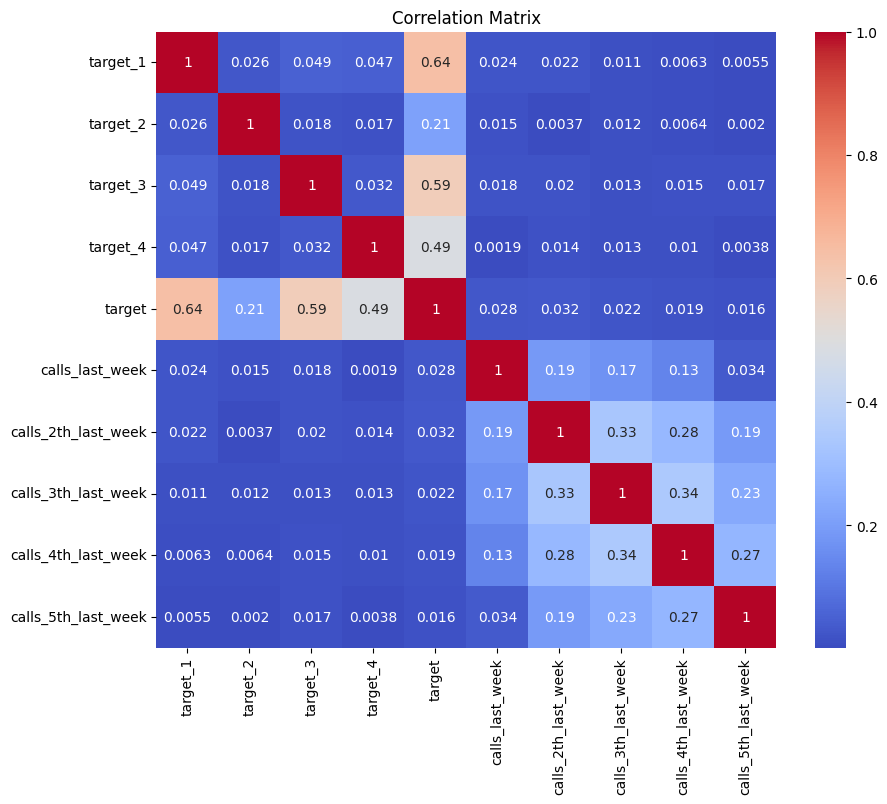

In [91]:
corr_cols = ['target_1', 'target_2', 'target_3', 'target_4', 'target',
             'calls_last_week', 'calls_2th_last_week',
           'calls_3th_last_week', 'calls_4th_last_week', 'calls_5th_last_week']

corr_matrix = df_merged[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### 1.6 Dialog time VS Purchases in the next month

In [97]:
### Prepare features
df_dialogs['dialog_count'] = [1 for _ in df_dialogs.index]
df_dialogs['event_time'] = pd.to_datetime(df_dialogs['event_time'])
df_dialogs['hour'] = df_dialogs['event_time'].dt.hour

df_dialogs['is_night'] = ((df_dialogs['hour'] >= 0) & (df_dialogs['hour'] < 6)).astype(int)
df_dialogs['is_morning'] = ((df_dialogs['hour'] >= 6) & (df_dialogs['hour'] < 12)).astype(int)
df_dialogs['is_day']     = ((df_dialogs['hour'] >= 12) & (df_dialogs['hour'] < 18)).astype(int)
df_dialogs['is_evening'] = ((df_dialogs['hour'] >= 18) & (df_dialogs['hour'] < 24)).astype(int)

for h in range(24):
    df_dialogs[f"hour_{h}"] = (df_dialogs['hour'] == h).astype(int)

agg_dict = {
    'dialog_count': 'size',
    'is_night': 'sum',
    'is_morning': 'sum',
    'is_day': 'sum',
    'is_evening': 'sum'
}
agg_dict.update({f"hour_{h}": 'sum' for h in range(24)})

df_dialogs_agg = df_dialogs.groupby(['client_id', 'mon']).agg(agg_dict).reset_index()

### Merge with targets
df_merged = pd.merge(df_targets, df_dialogs_agg, on=['client_id', 'mon'], how='left')

df_merged['target'] = df_merged[['target_1', 'target_2', 'target_3', 'target_4',]].max(axis=1)
df_merged.fillna(0, inplace=True)


In [98]:
# df_dialogs_agg

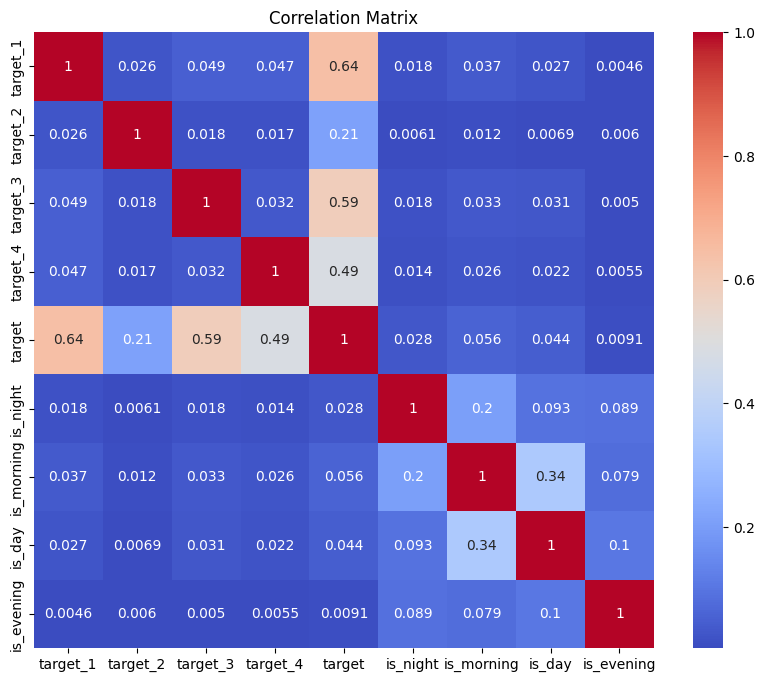

In [100]:
corr_cols = ['target_1', 'target_2', 'target_3', 'target_4', 'target',
             'is_night', 'is_morning', 'is_day', 'is_evening']

corr_matrix = df_merged[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

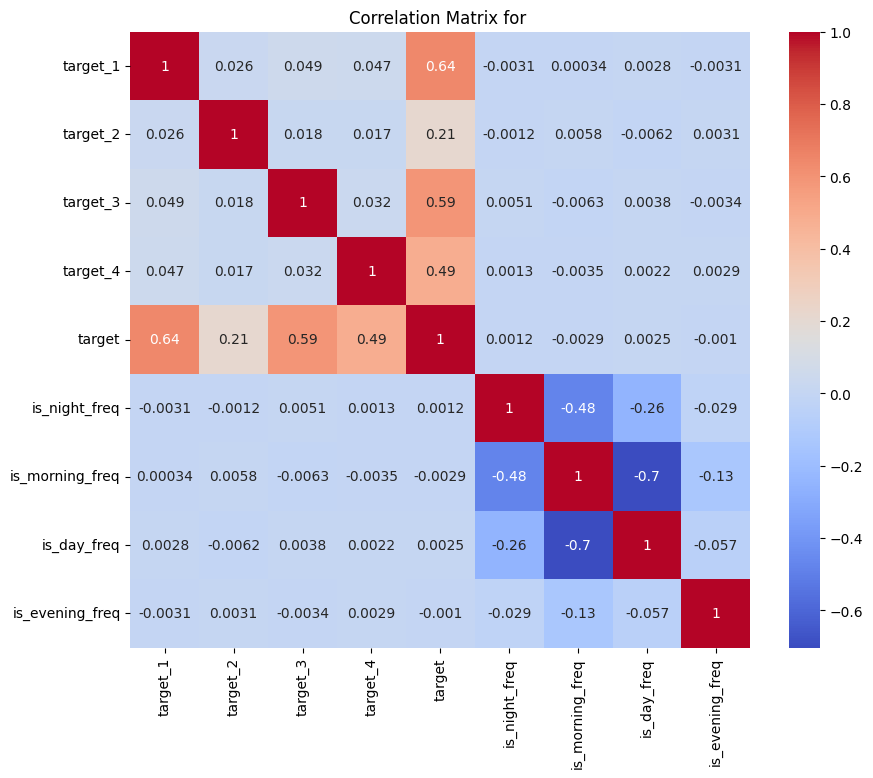

In [101]:
### Frequency
for col in ['is_night', 'is_morning', 'is_day', 'is_evening']:
    df_merged[f'{col}_freq'] = df_merged[col] / df_merged['dialog_count']

corr_cols = ['target_1', 'target_2', 'target_3', 'target_4', 'target',
             'is_night_freq', 'is_morning_freq', 'is_day_freq', 'is_evening_freq']

corr_matrix = df_merged[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for ')
plt.show()

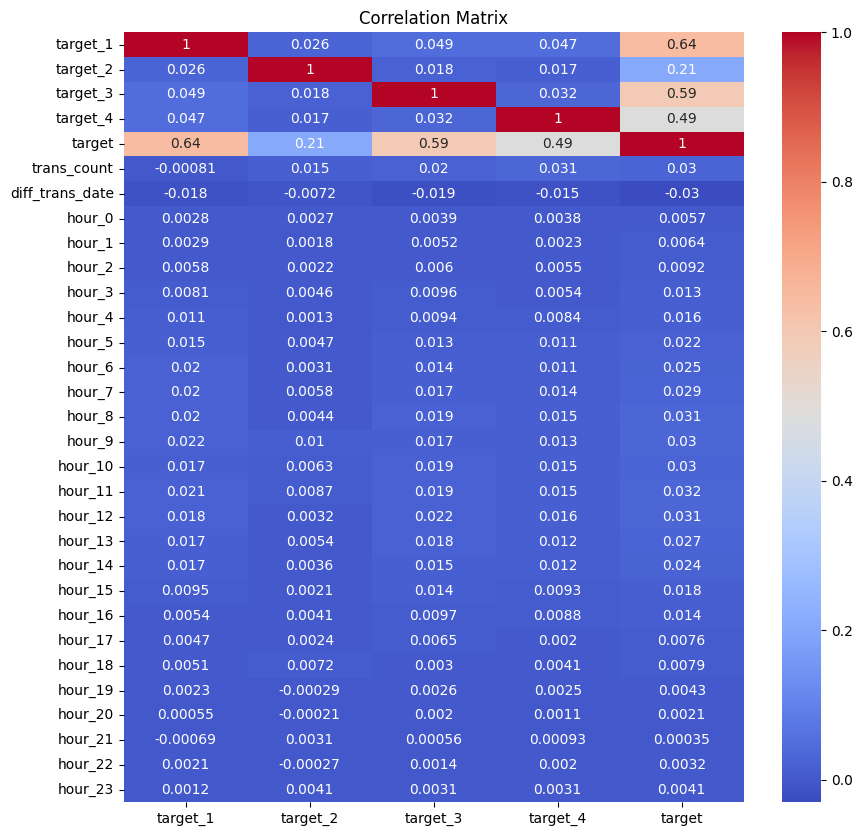

In [102]:
corr_cols = ['target_1', 'target_2', 'target_3', 'target_4', 'target',
    'trans_count', 'diff_trans_date', 
    'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
    'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
    'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
    'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23'
]

corr_matrix = df_merged[corr_cols].corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix[['target_1', 'target_2', 'target_3', 'target_4', 'target']], annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### 1.7 Commulative number of dialogs VS Targets

In [103]:
df_monthly = df_dialogs.groupby(['client_id', 'mon']).size().reset_index(name='calls')
df_monthly = df_monthly.sort_values(['client_id', 'mon'])
df_monthly.head()


,client_id,mon,calls
0,000032cc38caee45fe031778bcf6af05aa2aabe476acb8...,2022-08-01,4
1,000032cc38caee45fe031778bcf6af05aa2aabe476acb8...,2022-09-01,2
2,000032cc38caee45fe031778bcf6af05aa2aabe476acb8...,2023-01-01,1
3,00005e39da5fb5968996cd49130281c8bd074a42e0e17a...,2022-06-01,1
4,00041153285f5849bf5014a9b4aa7bcc8912ecf51ea39c...,2021-04-01,1


In [104]:
windows = [1, 2, 3, 6, 12]

for w in tqdm(windows):
    col_name = f'calls_last_{w}_months'
    df_monthly[col_name] = df_monthly.groupby('client_id')['calls'].transform(
        lambda x: x.rolling(window=w, min_periods=1).sum()
    )

df_merged = pd.merge(
    df_targets,
    df_monthly,
    on=['client_id', 'mon'],  
    how='left'  
)
df_merged = df_merged.fillna(0.)
df_merged['target'] = df_merged[['target_1', 'target_2', 'target_3', 'target_4',]].max(axis=1)

  0%|          | 0/5 [00:00<?, ?it/s]

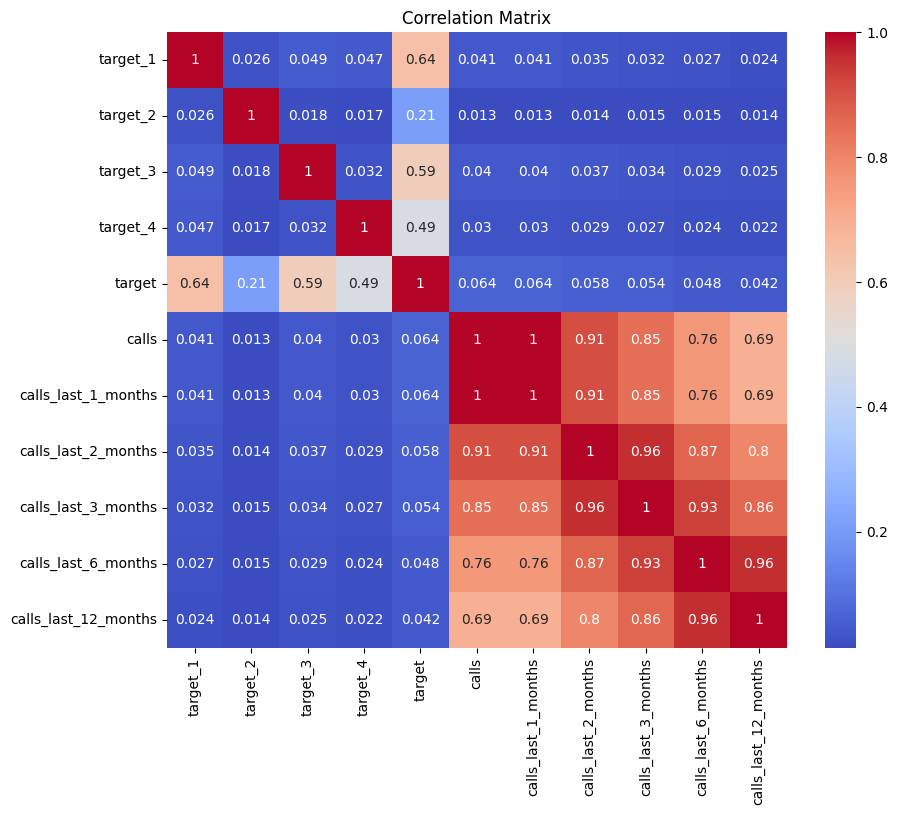

In [105]:

corr_cols = ['target_1', 'target_2', 'target_3', 'target_4', 'target',
             'calls', 'calls_last_1_months',
           'calls_last_2_months', 'calls_last_3_months', 'calls_last_6_months',
           'calls_last_12_months']

corr_matrix = df_merged[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### 1.8 Embedings

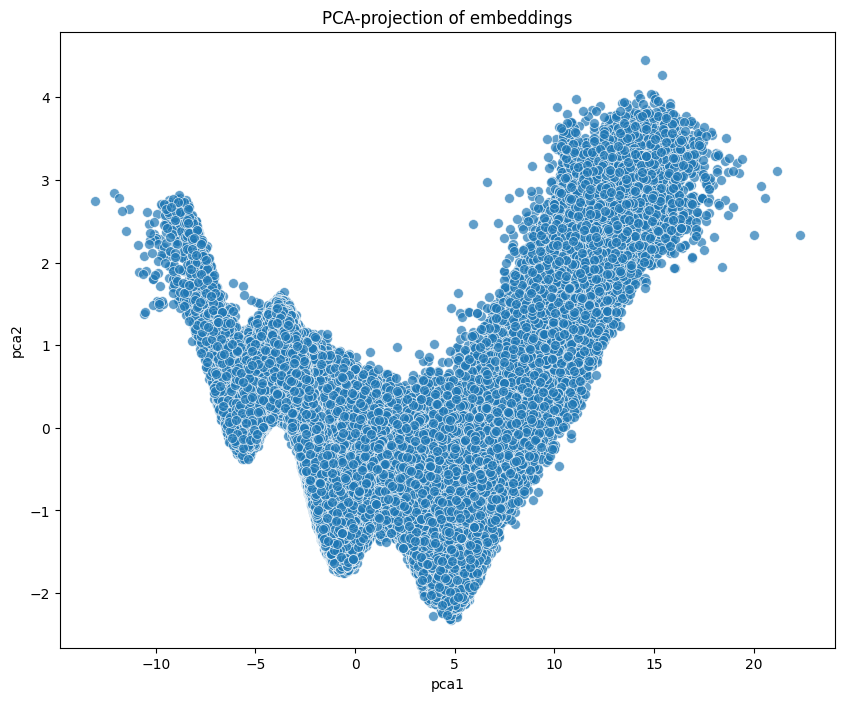

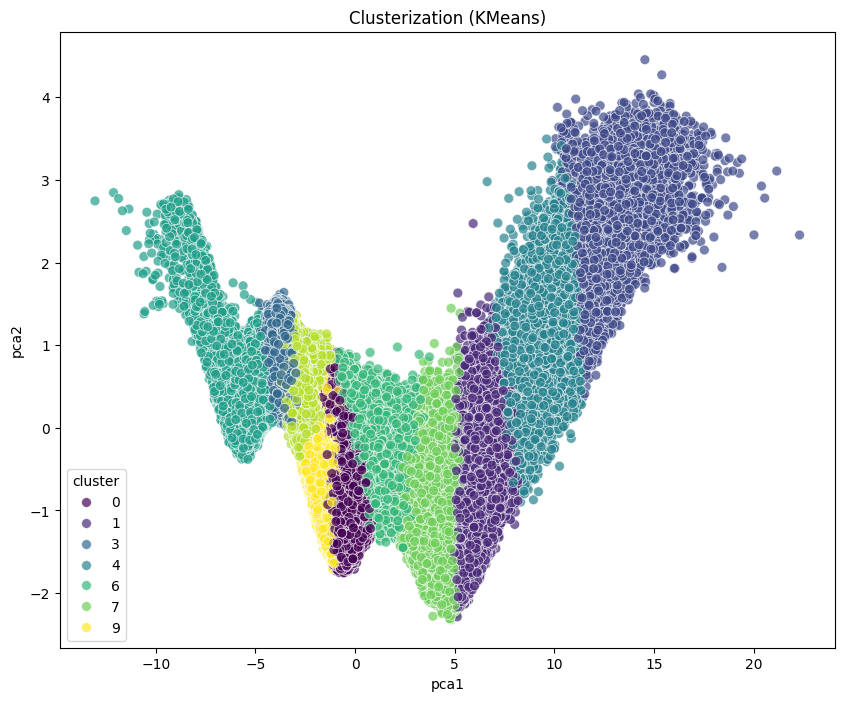

In [117]:
embeddings = np.vstack(df_dialogs['embedding'].values)

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

df_dialogs['pca1'] = embeddings_2d[:, 0]
df_dialogs['pca2'] = embeddings_2d[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(x='pca1', y='pca2', data=df_dialogs, s=50, alpha=0.7)
plt.title("PCA-projection of embeddings")
plt.show()

kmeans = KMeans(n_clusters=10, random_state=42)
df_dialogs['cluster'] = kmeans.fit_predict(embeddings)

plt.figure(figsize=(10, 8))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=df_dialogs, palette='viridis', s=50, alpha=0.7)
plt.title("Clusterization (KMeans)")
plt.show()


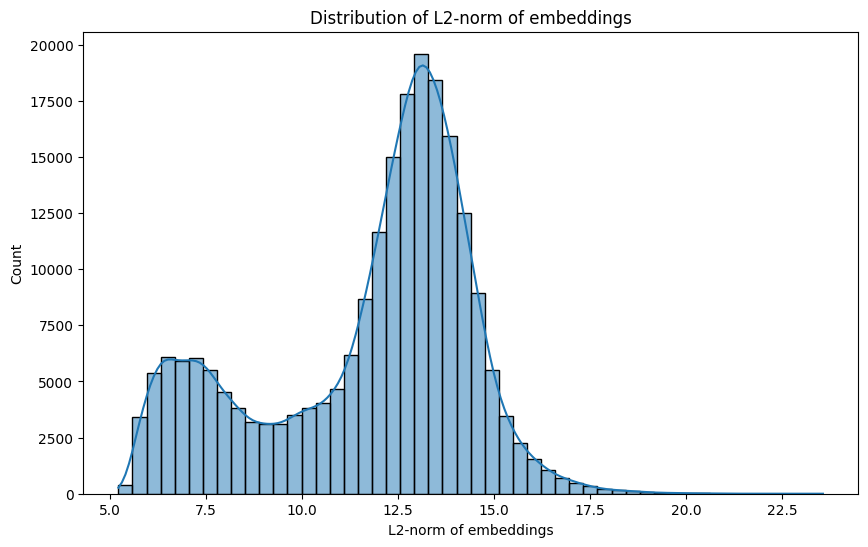

In [118]:
df_dialogs['emb_norm'] = [np.linalg.norm(x) for x in embeddings]

plt.figure(figsize=(10, 6))
sns.histplot(df_dialogs['emb_norm'], bins=50, kde=True)
plt.title("Distribution of L2-norm of embeddings")
plt.xlabel("L2-norm of embeddings")
plt.show()


#### 1.9 PCA 1,2 vectors, L2 norm VS targets

In [119]:
df_dialogs_monthly = (
    df_dialogs[['client_id', 'mon', 'pca1', 'pca2', 'cluster', 'emb_norm']]
    .groupby(['client_id', 'mon'])
    .mean()
)

df_merged = pd.merge(
    df_targets,
    df_dialogs_monthly,
    on=['client_id', 'mon'],  
    how='left'  
)
df_merged['target'] = df_merged[['target_1', 'target_2', 'target_3', 'target_4',]].max(axis=1)
df_merged['has_dialog'] = ~(df_merged['pca1'].isna())

for col in ['pca1', 'pca2', 'cluster', 'emb_norm']:
    df_merged[col] = df_merged[col].fillna(df_merged[col].mean())
    
df_merged['emb_norm'] = df_merged['emb_norm'].fillna(df_merged['emb_norm'].mean())



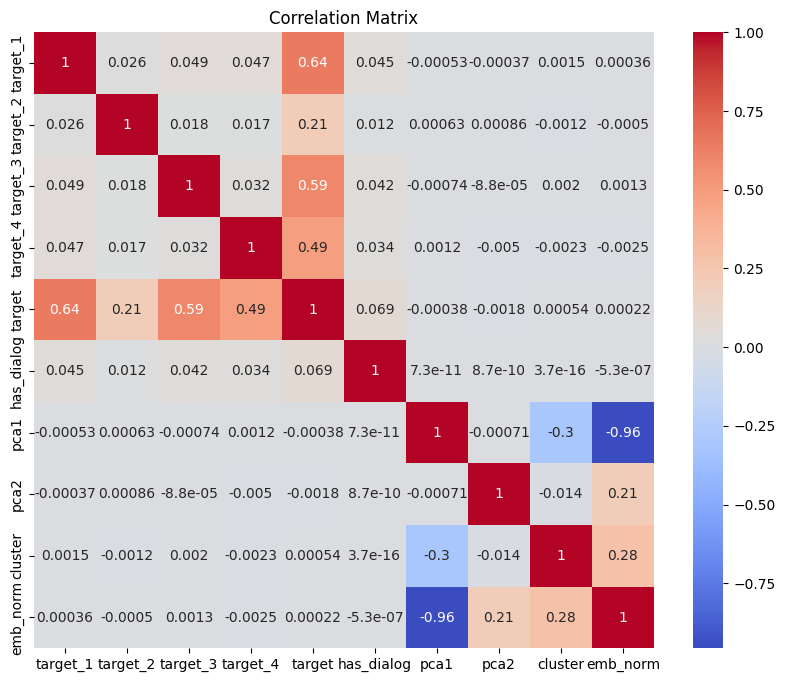

In [120]:
corr_cols = ['target_1', 'target_2', 'target_3', 'target_4', 'target',
              'has_dialog', 'pca1', 'pca2', 'cluster', 'emb_norm']

corr_matrix = df_merged[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [412]:
# df_dialogs_monthly

#### 1.10 PCA 1-5 vectors, L2 norm and clusters centers for the emmbeding of the last dialog VS targets

In [122]:
df_last_emb = df_dialogs.sort_values('event_time').groupby(['client_id', 'mon']).tail(1).copy()
df_last_emb['embedding'] = df_last_emb['embedding'].apply(lambda x: np.array(x) if not isinstance(x, np.ndarray) else x)
df_last_emb['emb_norm'] = df_last_emb['embedding'].apply(lambda x: np.linalg.norm(x))

### PCA
emb_matrix = np.vstack(df_last_emb['embedding'].values)
pca = PCA(n_components=5, random_state=42)
emb_pca = pca.fit_transform(emb_matrix)

for i in range(5):
    df_last_emb[f'pca_{i+1}'] = emb_pca[:, i]
emb_matrix = np.vstack(df_last_emb['embedding'].values)

### KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(emb_matrix)

df_last_emb['cluster'] = clusters



In [123]:
df_merged = pd.merge(df_targets, df_last_emb[['client_id', 'mon', 'emb_norm', 'cluster',] + [f'pca_{i+1}' for i in range(5)]],
                     on=['client_id', 'mon'], how='left')

df_merged['has_dialog'] = df_merged['emb_norm'].notnull().astype(int)

for col in [f'pca_{i+1}' for i in range(5)] + ['emb_norm']:
    df_merged[col] = df_merged[col].fillna(df_merged[col].mean())
    
df_merged['cluster'] = df_merged['cluster'].fillna(-1)
df_merged['cluster_cat'] = df_merged['cluster'].astype('category')

df_merged = pd.get_dummies(df_merged, columns=['cluster_cat'], prefix='cluster')
df_merged['target'] = df_merged[['target_1', 'target_2', 'target_3', 'target_4',]].max(axis=1)


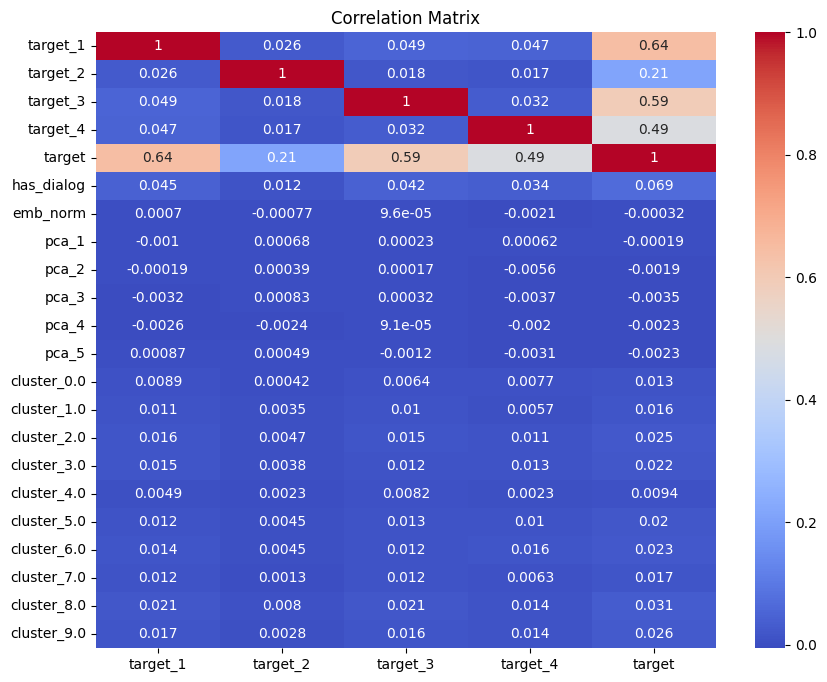

In [124]:
corr_cols = ['target_1', 'target_2', 'target_3', 'target_4', 'target',]
corr_cols += ['has_dialog', 'emb_norm'] + [f'pca_{i+1}' for i in range(5)] + [f'cluster_{i}.0' for i in range(10)] 

corr_matrix = df_merged[corr_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix[['target_1', 'target_2', 'target_3', 'target_4', 'target']], annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
